# Input Data

In [33]:
import pandas as pd
import torch
import numpy as np
import networkx as nx

In [7]:
path = "hw2_data/"
dss = ['dataset1','dataset2','dataset3'] #datasets
dataset = dict()
for ds in dss:
    dataset[ds] = dict()
    dataset[ds]['content'] = pd.read_csv(path+ds+"/content.csv",delimiter = '\t',header = None)
    dataset[ds]['train'] = pd.read_csv(path+ds+"/train.csv",delimiter = ',')
    dataset[ds]['test'] = pd.read_csv(path+ds+"/test.csv",delimiter = ',')
    dataset[ds]['upload'] = pd.read_csv(path+ds+"/upload.csv",delimiter = ',')
dataset[dss[2]]['test'].head()

,id,to,from
0,E370,26,317
1,E667,196,323
2,E3190,739,468
3,E848,576,156
4,E2161,466,199


## Data Explore

In [24]:
print(dataset[dss[0]]['content'].shape)
print(len(dataset[dss[0]]['content']))
np.array(dataset[dss[0]]['content'].iloc[0,1:]).shape

(2708, 1434)
2708


(1433,)

In [37]:
print(dataset[dss[0]]['train'].shape)
print(len(dataset[dss[0]]['train']))
dataset[dss[0]]['train'].iloc[1,:]

(8686, 4)
8686


id       E10255
to         2397
from       1144
label         1
Name: 1, dtype: object

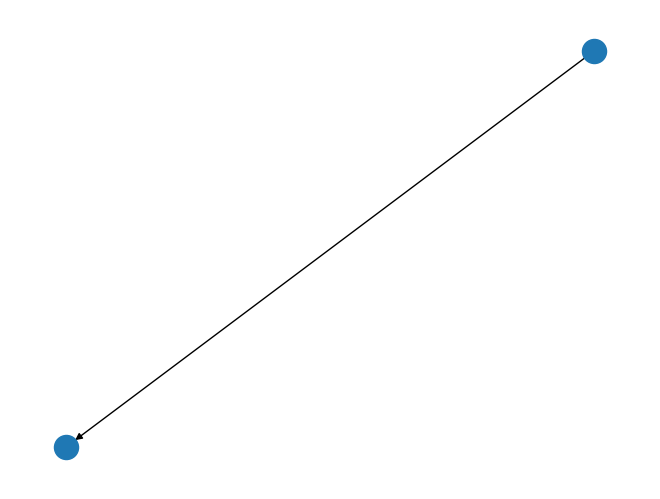

In [38]:
G = nx.DiGraph()
G.add_edge(0,1,label=0)
nx.draw(G)

---
# Main

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [11]:
def set_random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

## Data Preprocessing

In [41]:
def preprocess_features(features):
    # Row-normalize feature matrix and convert to tuple representation
    # Because the datasets only have binary features, row-normalize is unnecessary
    rowsum = np.array(features.sum(1))
    rowsum = (rowsum==0)*1+rowsum
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)
    return features

In [ ]:
def load_data(content,train):
    G = nx.Digraph()
    graph_node_features_dict = dict()
    
    for i in range(len(content)):
        graph_node_features_dict[content.iloc[i,0]] = np.array(content.iloc[i,1:])

    for i in train:
        # Adding nodes into G
        if i['from'] not in G:
            G.add_node(i['from'],features = graph_node_features_dict[i['from']])
        if i['to'] not in G:
            G.add_node(i['to'],features = graph_node_features_dict[i['to']])
            
        # Adding edges
        G.add_edge(i['from'],i['to'],label = i['label'])
    
    adj = nx.adjacency_matrix(G,sorted(G.nodes()))
    
    features = np.array(
        [features for _, features in sorted(G.nodes(data='features'), key=lambda x: x[0])])
    features = preprocess_features(features)
    g = adj

In [12]:
# Prepare the data
def prepare_data():
    

In [ ]:
    #load data from .mat or download from Planetoid dataset.
    
    if args.data_name in ('cora', 'citeseer', 'pubmed'):
        data = load_Planetoid_data(args)
        data = split_edges(data,args)
    elif args.data_name in ('chameleon','squirrel','film','cornell','texas','wisconsin'):
        datastr = args.data_name
        split_index=str(0)## this split is node-classification split from geom-gcn, not for link prediction
        splitstr = 'data/new_data_splits/'+datastr+'_split_0.6_0.2_'+split_index+'.npz'
        g, features, labels, _, _, _, num_features, num_labels = new_load_data(datastr,splitstr)
        A=g.toarray()
        edge_index,_=dense_to_sparse(torch.tensor(A))
        data=Data(edge_index=edge_index,x=features.to(torch.float))
        data = split_edges(data,args)
    else:
        if args.use_splitted == True: #use splitted train/val/test
            data = load_splitted_data(args)
        else:
            data = load_unsplitted_data(args)
            data = split_edges(data,args)
    
    

    set_random_seed(args.seed)
    data_observed,feature_results= set_init_attribute_representation(data,args)

    #Construct train, val and test data loader.
    set_random_seed(args.seed)
    train_graphs = []
    val_graphs = []
    test_graphs = []
    for i in range(data.train_pos.size(1)):
        train_graphs.append(minus_edge(data_observed,1,data.train_pos[:,i],args))

    for i in range(data.train_neg.size(1)):
        train_graphs.append(plus_edge(data_observed,0,data.train_neg[:,i],args))

    for i in range(data.test_pos.size(1)):
        test_graphs.append(plus_edge(data_observed,1,data.test_pos[:,i],args))

    for i in range(data.test_neg.size(1)):
        test_graphs.append(plus_edge(data_observed,0,data.test_neg[:,i],args))   
    if args.observe_val_and_injection == False:
        for i in range(data.val_pos.size(1)):
            val_graphs.append(plus_edge(data_observed,1,data.val_pos[:,i],args))

        for i in range(data.val_neg.size(1)):
            val_graphs.append(plus_edge(data_observed,0,data.val_neg[:,i],args))
    else:
        for i in range(data.val_pos.size(1)):
            val_graphs.append(minus_edge(data_observed,1,data.val_pos[:,i],args))

        for i in range(data.val_neg.size(1)):
            val_graphs.append(plus_edge(data_observed,0,data.val_neg[:,i],args))


    
    print('Train_link:', str(len(train_graphs)),' Val_link:',str(len(val_graphs)),' Test_link:',str(len(test_graphs)))

    train_loader = DataLoader(train_graphs,batch_size=args.batch_size,shuffle=True)
    val_loader = DataLoader(val_graphs,batch_size=args.batch_size,shuffle=True)
    test_loader = DataLoader(test_graphs,batch_size=args.batch_size,shuffle=False)

    return train_loader, val_loader, test_loader,feature_results
